# Data Analysis

##  Objectives
- Understand the distribution of tags
- Analyze the number of tags per problem
- Examine the 8 focus tags
- Identify data quality issues
- Prepare insights for modeling

In [1]:
import sys
sys.path.append('..') 
# i had to add the parent directory to sys.path so i can import function and constant ffrom modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from code_classifier.data import load_dataset_as_dataframe
from code_classifier.preprocessing import DEFAULT_FOCUS_TAGS, filter_to_focus_tags



In [3]:
# Load the dataset
df = load_dataset_as_dataframe('../data', ["description", "code"])

print(f"Total number of examples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total number of examples: 4982
Columns: ['problem_id', 'text_description', 'text_code', 'tags']

First few rows:


,problem_id,text_description,text_code,tags
0,sample_0,"Numbers $$$1, 2, 3, \dots n$$$ (each integer f...",\ndef ii(): return int(input())\ndef mi(): ret...,"[greedy, constructive algorithms, math, implem..."
1,sample_1,"There are $$$n$$$ positive integers $$$a_1, a_...",a = int(input())\nfor i in range(a):\n f = ...,"[number theory, greedy]"
2,sample_10,You are given an undirected graph consisting o...,def read_nums():\n return [int(x) for x in ...,"[dsu, greedy, graphs]"
3,sample_100,A positive (strictly greater than zero) intege...,t = int(input())\nfor i in range(t):\n canP...,"[implementation, math]"
4,sample_1000,"Polycarp is working on a new project called ""P...",import sys\nz=x=0\nfor s in sys.stdin:\n\tif s...,[implementation]


we can see the presence of latex delimiters in the text description , should take it into consideration for the cleaning/ preprocessing

In [50]:
# Analyze feature availability in raw JSON files
import json
import os

# Features i'm considering for the analysis
features_of_interest = {
    'description': 'prob_desc_description',
    'input_spec': 'prob_desc_input_spec',
    'output_spec': 'prob_desc_output_spec',
    'source_code': 'source_code',
}

# Count availability for each feature
feature_stats = {}
for feat_name, json_key in features_of_interest.items():
    feature_stats[feat_name] = {
        'present': 0,
        'missing': 0,
        'empty': 0,
        'non_empty': 0,
    }

# Analyze JSON files
data_dir = '../data'
total_files = 0
files_with_missing = []
files_with_empty = []

for filename in sorted(os.listdir(data_dir)):
    if not filename.startswith('sample_') or not filename.endswith('.json'):
        continue
    
    total_files += 1
    filepath = os.path.join(data_dir, filename)
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            record = json.load(f)
        
        has_missing = False
        for feat_name, json_key in features_of_interest.items():
            if json_key in record:
                feature_stats[feat_name]['present'] += 1
                value = record[json_key]
                if value is None or value == '':
                    feature_stats[feat_name]['empty'] += 1
                    files_with_empty.append(filename)
                else:
                    feature_stats[feat_name]['non_empty'] += 1
            else:
                feature_stats[feat_name]['missing'] += 1
                has_missing = True
        
        if has_missing:
            files_with_missing.append(filename)
    
    except Exception as e:
        print(f"Error reading {filename}: {e}")

# Display 
print(" ----- Feature Availability Analysis -----\n")
print(f"Total files analyzed: {total_files}\n")

for feat_name in features_of_interest.keys():
    stats = feature_stats[feat_name] #dictionnary
    present_pct = (stats['present'] / total_files) * 100
    non_empty_pct = (stats['non_empty'] / total_files) * 100
    
    print(f"--- {feat_name.upper()} ({features_of_interest[feat_name]}) ---")
    print(f"  Present in JSON: {stats['present']}/{total_files} ({present_pct:.1f}%)")
    print(f"  Missing from JSON: {stats['missing']}/{total_files} ({100-present_pct:.1f}%)")
    print(f"  Non-empty values: {stats['non_empty']}/{total_files} ({non_empty_pct:.1f}%)")
    print(f"  Empty/None values: {stats['empty']}/{total_files} ({(stats['empty']/total_files)*100:.1f}%)")
    print()

print(f'Files with at least an empty valy of the features of interest{files_with_empty[:5]}')



 ----- Feature Availability Analysis -----

Total files analyzed: 4982

--- DESCRIPTION (prob_desc_description) ---
  Present in JSON: 4982/4982 (100.0%)
  Missing from JSON: 0/4982 (0.0%)
  Non-empty values: 4982/4982 (100.0%)
  Empty/None values: 0/4982 (0.0%)

--- INPUT_SPEC (prob_desc_input_spec) ---
  Present in JSON: 4982/4982 (100.0%)
  Missing from JSON: 0/4982 (0.0%)
  Non-empty values: 4949/4982 (99.3%)
  Empty/None values: 33/4982 (0.7%)

--- OUTPUT_SPEC (prob_desc_output_spec) ---
  Present in JSON: 4982/4982 (100.0%)
  Missing from JSON: 0/4982 (0.0%)
  Non-empty values: 4897/4982 (98.3%)
  Empty/None values: 85/4982 (1.7%)

--- SOURCE_CODE (source_code) ---
  Present in JSON: 4982/4982 (100.0%)
  Missing from JSON: 0/4982 (0.0%)
  Non-empty values: 4982/4982 (100.0%)
  Empty/None values: 0/4982 (0.0%)

Files with at least an empty valy of the features of interest['sample_1026.json', 'sample_1072.json', 'sample_1217.json', 'sample_1276.json', 'sample_1400.json']


the problem description and the code are present and non empty in every single document, unlike input and output that are sometimes missing ( we won't take them into consideration in the modeling unlike i have enough time to figure out a goood method to deal with the missing values in vectorizing these features)

the reason i was interested in input and output description is because the description alone can be too narative and abstract, meanwhile I/O S and specially output is direct and expliccit to describe what is expected as a solution to the problem

In [51]:
# Number of tags per example
df['n_tags'] = df['tags'].apply(len)

print("----- Basic Statistics -----")
print(f"Average number of tags per problem: {df['n_tags'].mean():.2f}")
print(f"Median number of tags: {df['n_tags'].median():.0f}")
print(f"Min tags: {df['n_tags'].min()}")
print(f"Max tags: {df['n_tags'].max()}")
print(f"\nProblems with 0 tags: {(df['n_tags'] == 0).sum()}")
print(f"Problems with 1 tag: {(df['n_tags'] == 1).sum()}")
print(f"Problems with 2 tags: {(df['n_tags'] == 2).sum()}")
print(f"Problems with 3+ tags: {(df['n_tags'] >= 3).sum()}")

----- Basic Statistics -----
Average number of tags per problem: 2.80
Median number of tags: 3
Min tags: 0
Max tags: 11

Problems with 0 tags: 41
Problems with 1 tag: 857
Problems with 2 tags: 1455
Problems with 3+ tags: 2629


We notice the presence of some problems with no tags, these problems will most bprobably be dropped since they don't have no additional information to help us understand the relationship between features and tags

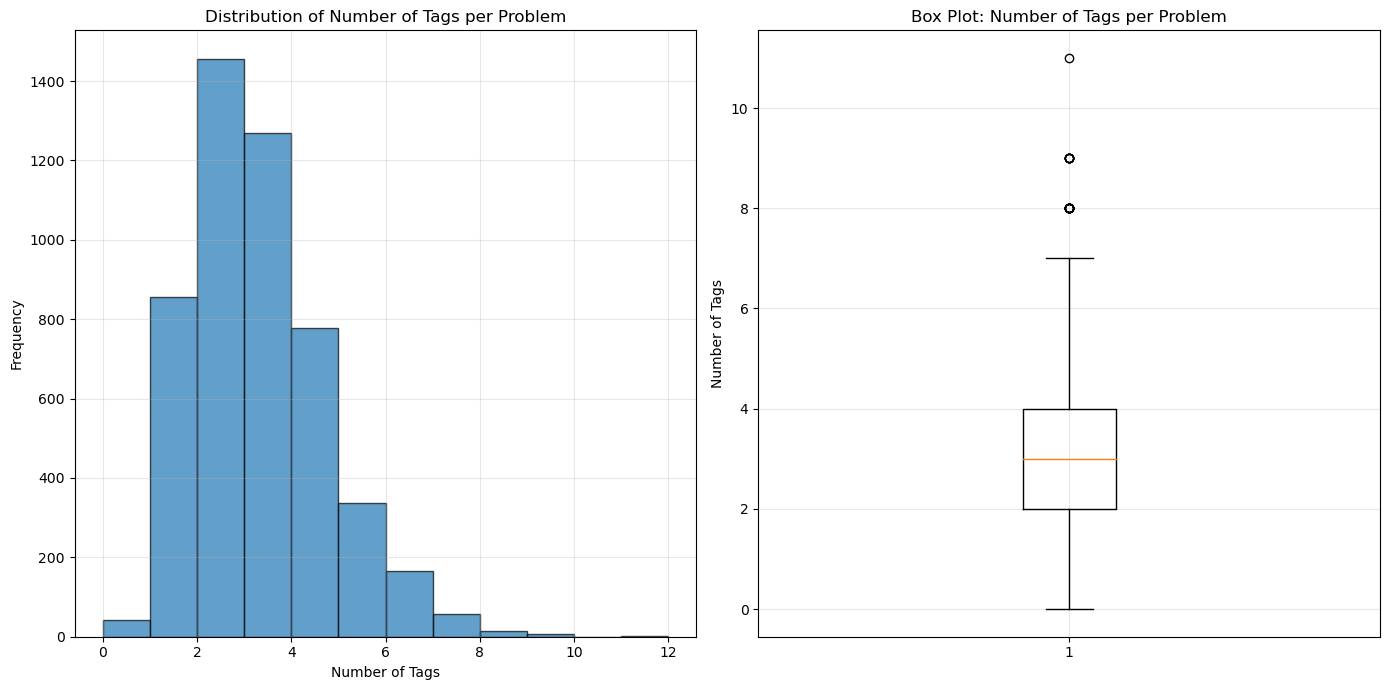

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Histogram
axes[0].hist(df['n_tags'], bins=range(0, df['n_tags'].max() + 2), edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Tags')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Number of Tags per Problem')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(df['n_tags'], vert=True)
axes[1].set_ylabel('Number of Tags')
axes[1].set_title('Box Plot: Number of Tags per Problem')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
all_tags = []
for tags in df['tags']:
    all_tags.extend(tags)

# Count tag occurrences
tag_counts = pd.Series(all_tags).value_counts()

print(f"Total number of unique tags: {len(tag_counts)}")
print(f"Total tag occurrences: {len(all_tags)}")

# Create DataFrame
tags_df = pd.DataFrame( columns = ['tag', 'count', 'percentage'])
for tag, count in tag_counts.items():
    tags_df.loc[len(tags_df)] = [tag, count, count / len(df) * 100]
    

print("\n ------ Top 20 Most Frequent Tags ------")
print(tags_df.head(20))

Total number of unique tags: 37
Total tag occurrences: 13952

 ------ Top 20 Most Frequent Tags ------
                        tag  count  percentage
0                    greedy   1743   34.985949
1            implementation   1597   32.055399
2                      math   1409   28.281815
3   constructive algorithms   1036   20.794862
4                        dp    984   19.751104
5               brute force    837   16.800482
6           data structures    783   15.716580
7                  sortings    671   13.468487
8             binary search    567   11.380971
9                    graphs    542   10.879165
10          dfs and similar    508   10.196708
11                  strings    422    8.470494
12            number theory    350    7.025291
13                    trees    324    6.503412
14             two pointers    320    6.423123
15            combinatorics    273    5.479727
16                 bitmasks    256    5.138499
17                      dsu    176    3.532718
18  

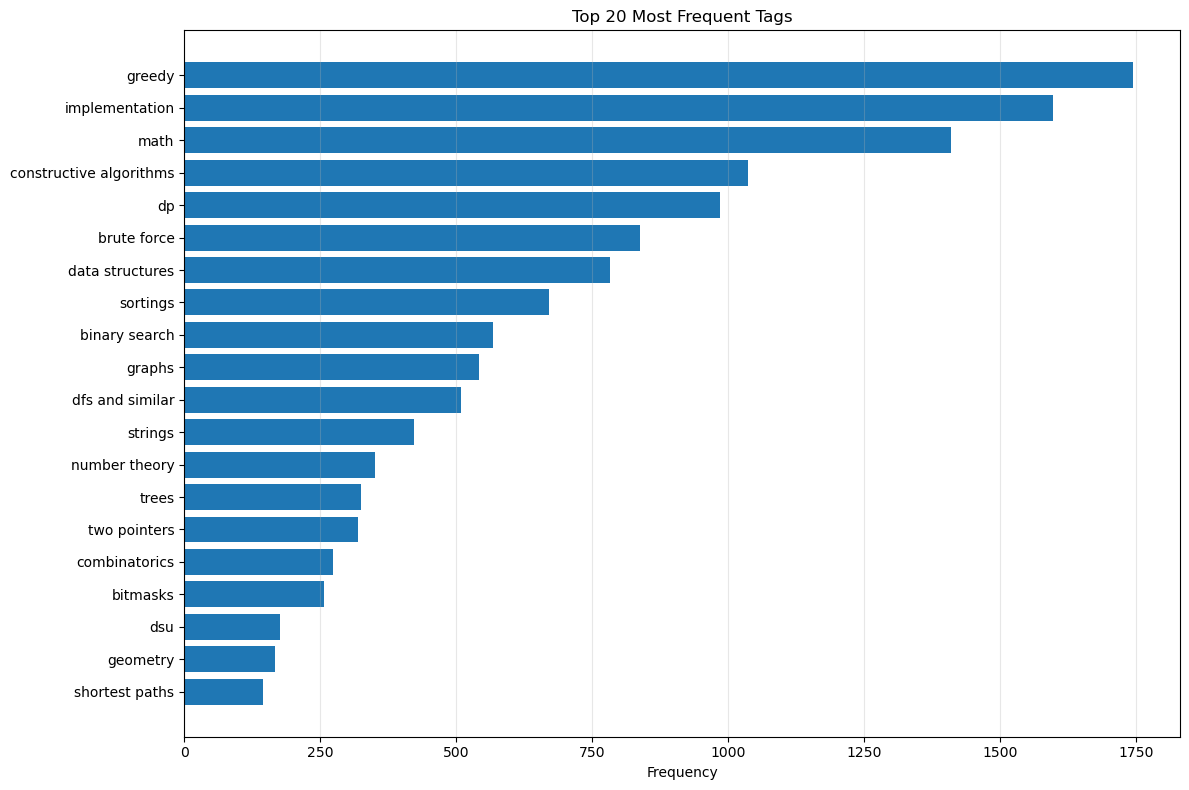

In [54]:
# Visualize top tags
top_20 = tags_df.head(20)

plt.figure(figsize=(12, 8))
y_pos = range(len(top_20))
plt.barh(y_pos, top_20['count'])

plt.yticks(y_pos, top_20['tag'])
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Tags')

plt.gca().invert_yaxis() #biggest tag on top
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

Despite not being in the 8 focus tags, Greedy is the most present one in the overall problemswith a percentage of 34% (maybe it was ignored because it difficult to detect)

In [55]:
print("Focus tags:", DEFAULT_FOCUS_TAGS)
print("\n----- Focus Tags Statistics ------\n")

# Extract focus tags 
focus_df = tags_df[tags_df['tag'].isin(DEFAULT_FOCUS_TAGS)].copy()

#no need to sort the values since we already have the tags sorted by frequency

print(focus_df.to_string(index=False))

Focus tags: ('math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities')

----- Focus Tags Statistics ------

          tag  count  percentage
         math   1409   28.281815
       graphs    542   10.879165
      strings    422    8.470494
number theory    350    7.025291
        trees    324    6.503412
     geometry    166    3.331995
        games    105    2.107587
probabilities     92    1.846648


Clearly there is a huge imbalance between the classes we have between our hands,  mainly dominated by Math that has an occurence of 3 times  what the second most frequent one has ( Graphs )

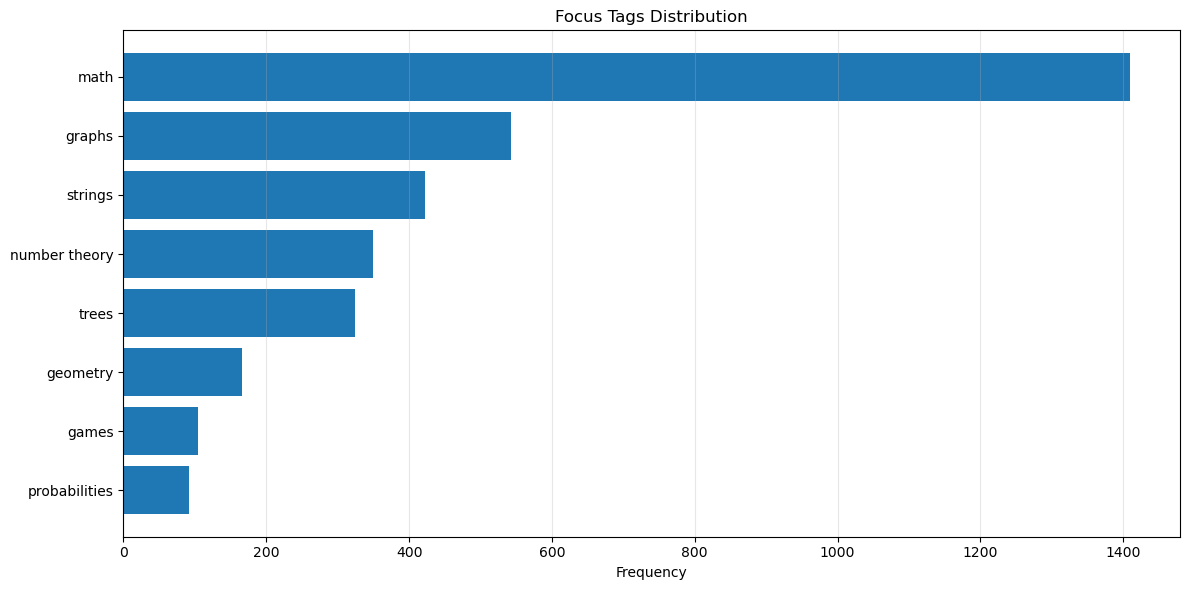

In [56]:
# Visualize focus tags
plt.figure(figsize=(12, 6))
y_pos = range(len(focus_df))
plt.barh(y_pos, focus_df['count'])
plt.yticks(y_pos, focus_df['tag'])
plt.xlabel('Frequency')
plt.title('Focus Tags Distribution')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [57]:
# How many problems have at least one focus tag?
focus_tags_set = set(DEFAULT_FOCUS_TAGS)
has_focus_tag_count = 0
for tags in df['tags']:
    if bool(set(tags) & focus_tags_set):
        has_focus_tag_count += 1

no_focus_tag_count = len(df) - has_focus_tag_count
print(f"Problems with at least one focus tag: {has_focus_tag_count} ({has_focus_tag_count / len(df) * 100:.1f}%)")
print(f"Problems with NO focus tags: {no_focus_tag_count} ({no_focus_tag_count / len(df) * 100:.1f}%)")

Problems with at least one focus tag: 2678 (53.8%)
Problems with NO focus tags: 2304 (46.2%)


this is very important , if we choose to focus only on the 8 tags mentionned in the pdf, and drop problems that are not related to these 8, we'll be sacrificing approximatly 46% of the dataset ( almost half !!!)

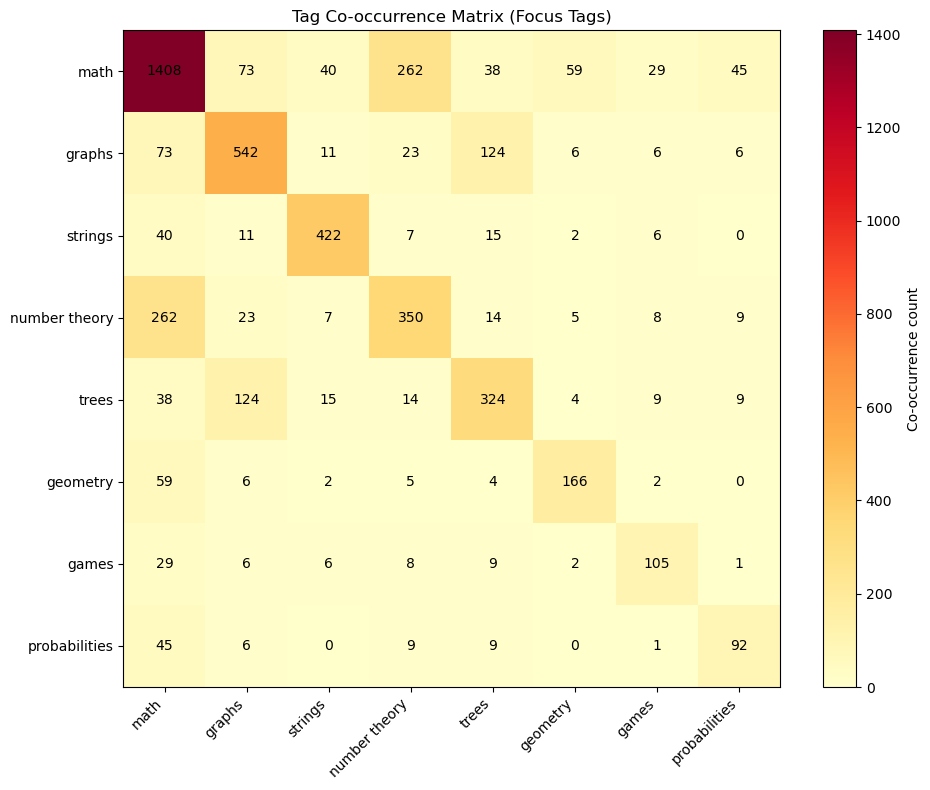

In [58]:
# Co-occurrence matrix for focus tags
# First, filter to rows that have at least one focus tag
df_focus = filter_to_focus_tags(df, DEFAULT_FOCUS_TAGS)

n_tags = len(DEFAULT_FOCUS_TAGS)
co_occurrence = np.zeros((n_tags, n_tags))

#  co-occurrences
for tags in df_focus['tags']:
    # Get indices of focus tags present in this row
    present_indices = []
    for i, tag in enumerate(DEFAULT_FOCUS_TAGS):
        if tag in tags:
            present_indices.append(i)
    
    # Increment co-occurrence for all pairs
    for i in present_indices:
        for j in present_indices:
            co_occurrence[i, j] += 1

# heatmap 
plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence, cmap='YlOrRd')
plt.colorbar(label='Co-occurrence count')
plt.xticks(range(n_tags), DEFAULT_FOCUS_TAGS, rotation=45, ha='right')
plt.yticks(range(n_tags), DEFAULT_FOCUS_TAGS)
plt.title('Tag Co-occurrence Matrix (Focus Tags)')

# Add text annotations
for i in range(n_tags):
    for j in range(n_tags):
        plt.text(j, i, int(co_occurrence[i, j]), ha='center', va='center')

plt.tight_layout()
plt.show()

In [67]:
# Analyze description lengths
text_lengths = []
text_word_counts = []

df['text_length'] = df['text_description'].apply(len)
df['text_word_count'] = df['text_description'].apply(lambda x: len(x.split()) if x else 0)


print("=== Text Statistics ===")
print(f"Average character length: {df['text_length'].mean():.0f}")
print(f"Median character length: { df['text_length'].median():.0f}")
print(f"Min length: {df['text_length'].min()}")
print(f"Max length: {df['text_length'].max()}")
print(f"\nAverage word count: {df['text_word_count'].mean():.0f}")
print(f"Median word count: {df['text_word_count'].median():.0f}")

=== Text Statistics ===
Average character length: 951
Median character length: 874
Min length: 63
Max length: 3796

Average word count: 167
Median word count: 155


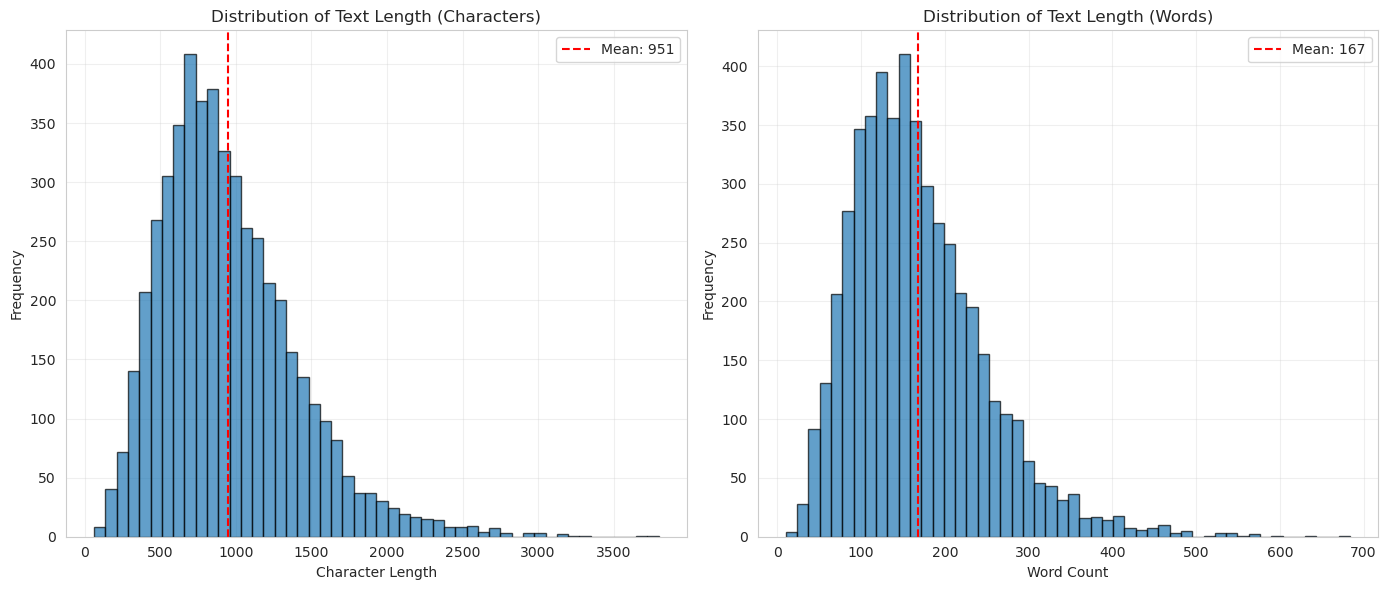

In [ ]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Character length histogram
axes[0].hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Text Length (Characters)')
mean_char = np.mean(text_lengths)
axes[0].axvline(mean_char, color='red', linestyle='--', label=f'Mean: {mean_char:.0f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Word count histogram
axes[1].hist(df['text_word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Text Length (Words)')
mean_words = np.mean(text_word_counts)
axes[1].axvline(mean_words, color='red', linestyle='--', label=f'Mean: {mean_words:.0f}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights 

Based on the analysis above, we can draw several insights:

1. **Class Imbalance**: Some tags are much more frequent than others. We should consider class balancing strategies.

2. **Multi-label Nature**: Most problems have 2-3 tags. This is a true multi-label classification problem.

3. **Focus Tags Coverage**: Check how well the 8 focus tags are represented in the dataset.

4. **Text Length**: Understanding text length distribution helps with feature extraction (TF-IDF parameters).

5. **Co-occurrence**: Some tags often appear together, which could inform model architecture choices.